# __EDA & Vintage Analysis__ on Credit Card Application Dataset

Vintage analysis is a widely-used method for managing credit risk, it illustrate the behavior after an account was opened. Based on same origination period, it calculates charge-off ratio of a loan portfolio. 

Here comes our datasets, in which `credit_record.csv` contains loan accounts' credit records, the detailed data explanation is here:

|  credit_record.csv           | 　                        | 　                                                                                                                                                                                                                            |
|:-----------------------:|---------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Feature name          | Explanation               | Remarks                                                                                                                                                                                                                       |
| ID                    | Client number             | 　                                                                                                                                                                                                                            |
| MONTHS_BALANCE        | Record month              | The month of the extracted data is the starting point,  backwards, 0 is the current month, -1 is the previous month,  and so on                                                                                               |
| STATUS               | Status                    | 0: 1-29 days past due 1: 30-59 days past due   2: 60-89 days overdue 3: 90-119 days overdue    4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days    C: paid off that month X: No loan for the month  |



-----



while the `application_record.csv` contains appliers' features, such as gender, income. This notebook will show some necessary EDA on credit_record table.

In [1]:
#import library
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
credit = pd.read_csv('credit_record.csv', delimiter=',')  
application = pd.read_csv('application_record_new.csv', delimiter=';')

In [2]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [3]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
len(set(application['ID'])) # how many unique ID in application record?

438510

In [5]:
len(set(credit['ID'])) # how many unique ID in credit record?

45985

In [6]:
grouped = credit.groupby('ID')
### convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe window
pivot_tb.reset_index(drop = True, inplace = True)
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left') # join calculated information
credit0 = credit.copy()
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

##### denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']

##### vintage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum'] 
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] #delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') #join sta_sum colun to vintage table
vintage

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [7]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers
vintage        

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


In [8]:
#use pivot to convert long data
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,0.024691,0.024691,0.026749,0.032922,0.034979,0.037037,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,0.019231,0.019231,0.023504,0.027778,0.027778,0.029915,0.029915,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,NaN,Na

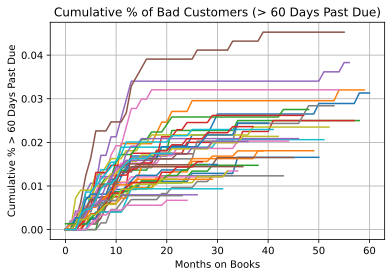

In [9]:
# plot vintage line chart
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

### This is a standard vintage analysis table. The rows represent months of opening accounts, columns represent months after openning acounts, and values are accumulate past-due rate. As open-month closes to 0, the observe window shortens, thus the bottom half triangular field is filled by nan.

# Observe Window Analysis

Because of two reasons, account cancellation and observe over, our observe on accounts will be truncated. Observe window is a significant parameter to be considered. If observe window is too short, users' behavior will not fully show off, which will bring unnecessary noise to our data.

In order to observe how many accounts increase as observe window extend, we plot this. 

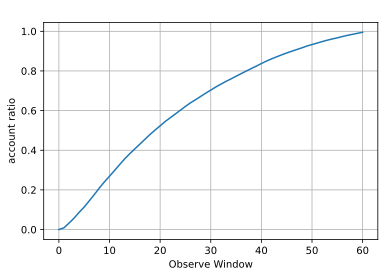

In [10]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['window'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = ' ')
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

We could see that a 60 months observe window covers all appliers, while 20 months window contains about 52% records.

In [11]:
def calculate_observe(credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

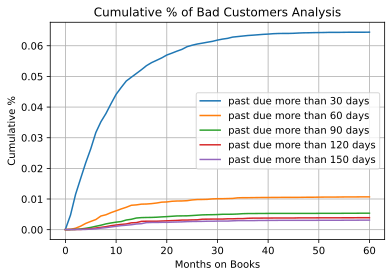

In [12]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })
obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

This plot could be seen as a average (across open-month) version of vintage plot.
For longer past due date, it needs longer observe window. For example, more than 150 days past due needs at least 5 months until first *bad customer* appears. For most situation, a 20-months observe window could cover most *bad customer*. However, For 30 days past due, we could see that after 30 months on books, there still are new *bad customer* join in the list.

# Overall Past-due Ratio

Calculating overall past-due rate. Respectively, we analyze 1 day past due, 20 days past due, 60 days past due, 90 days past due, 120 days past due, 150 days past due. This analysis could help us to define who are *bad customers*. We could see that almost 87% users have past due more than 1 day, which is too common, thus it's inappropriate to be a standard. What about 150 days overdue? Only 0.4% of accounts appear to past due that long. If we use that, we will left many *bad customers* in our scrutiny. A table will help us to determine what will be the most suitable standard of *bad customers*.

In [13]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit0['status'] = None
    exec(command) # execute input code
    sumagg = credit0.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit0.loc[(credit0['STATUS'] == '0') | (credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424


## Application record EDA 

In [14]:
application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [15]:
application.shape

(438557, 18)

In [16]:
application.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [17]:
#Check for duplicate records
application[application.duplicated()]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS


In [18]:
#Gender proportion in applicants
gender_val = application.CODE_GENDER.value_counts(normalize = True)
gender_val

F    0.671384
M    0.328616
Name: CODE_GENDER, dtype: float64

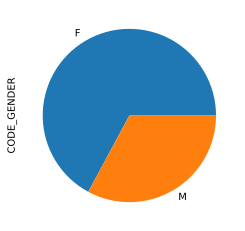

In [19]:
gender_val.plot.pie()
plt.show()

### Around 67.14% of the applicants are female

In [20]:
housing_val = application.NAME_HOUSING_TYPE.value_counts(normalize = True)
housing_val

House / apartment      0.898016
With parents           0.043499
Municipal apartment    0.032411
Rented apartment       0.013622
Office apartment       0.008943
Co-op apartment        0.003509
Name: NAME_HOUSING_TYPE, dtype: float64

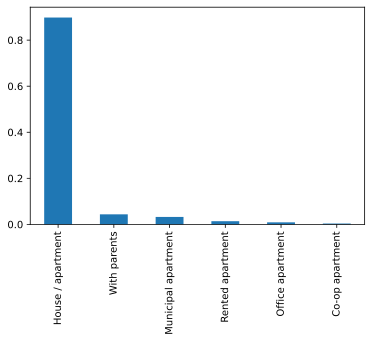

In [21]:
housing_val.plot.bar()
plt.show()

In [22]:
#House Ownership percentage
housing_ownership_count = application.groupby(['CODE_GENDER','NAME_HOUSING_TYPE']).agg({'ID': 'count'})
housing_ownership_count

ID
CODE_GENDER NAME_HOUSING_TYPE          
F           Co-op apartment         862
            House / apartment    267607
            Municipal apartment   10019
            Office apartment       2122
            Rented apartment       3284
            With parents          10546
M           Co-op apartment         677
            House / apartment    126224
            Municipal apartment    4195
            Office apartment       1800
            Rented apartment       2690
            With parents           8531

In [23]:
housing_ownership_percent = housing_ownership_count.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
housing_ownership_percent

ID
CODE_GENDER NAME_HOUSING_TYPE             
F           Co-op apartment       0.292759
            House / apartment    90.886768
            Municipal apartment   3.402731
            Office apartment      0.720690
            Rented apartment      1.115338
            With parents          3.581714
M           Co-op apartment       0.469757
            House / apartment    87.584393
            Municipal apartment   2.910829
            Office apartment      1.248985
            Rented apartment      1.866539
            With parents          5.919496

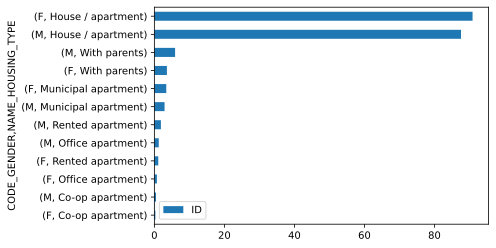

In [24]:
housing_ownership_percent.sort_values(by = 'ID').plot.barh()
plt.show()

In [25]:
#Mean & Median of amount income 
print(application.AMT_INCOME_TOTAL.mean()) #mean of total income
print(application.AMT_INCOME_TOTAL.median()) #median of total income

187524.2860095039
160780.5


## Credit record EDA 

In [26]:
creditEDA = pd.read_csv("credit_record.csv")
creditEDA.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [27]:
creditEDA.shape

(1048575, 3)

In [28]:
creditEDA.describe()

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


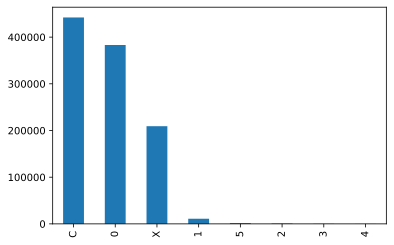

In [29]:
creditEDA.STATUS.value_counts().plot.bar()
plt.show()

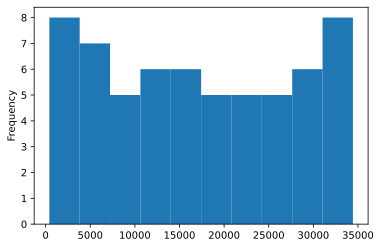

In [30]:
creditEDA.MONTHS_BALANCE.value_counts().plot.hist()
plt.show()

In [31]:
#Find out for how long each customer has had a card
creditEDA['MONTHS_BALANCE'] = creditEDA.MONTHS_BALANCE.apply(lambda x : x*(-1))
cardholder_tenure = pd.DataFrame(creditEDA.groupby('ID').agg({'MONTHS_BALANCE' : max}))
cardholder_tenure.rename(columns = {'MONTHS_BALANCE':'CUST_FOR_MONTHS'},inplace = True)
cardholder_tenure.head()

,CUST_FOR_MONTHS
ID,
5001711,3
5001712,18
5001713,21
5001714,14
5001715,59


In [32]:
cust_data = pd.merge(application,cardholder_tenure,on = 'ID',how = 'inner')
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26


In [33]:
cust_data.shape

(36457, 19)

In [34]:
creditEDA['STATUS'][creditEDA["STATUS"] == 'C'] = -1
creditEDA['STATUS'][creditEDA["STATUS"] == 'X'] = -1
creditEDA.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,-1
1,5001711,1,0
2,5001711,2,0
3,5001711,3,0
4,5001712,0,-1


In [35]:
creditEDA['STATUS'] = creditEDA.STATUS.apply(lambda x : int(x))
creditEDA.sort_values(by = 'STATUS',ascending = False,inplace = True)
creditEDA.drop_duplicates(subset = ['ID'],inplace = True)
creditEDA.shape

(45985, 3)

In [36]:
creditEDA['target'] = creditEDA.STATUS.apply(lambda x : 0 if x>=2 else 1)
creditEDA.drop(['STATUS','MONTHS_BALANCE'],axis = 1,inplace = True)
creditEDA.head()

,ID,target
372050,5042064,0
307952,5029028,0
723708,5097065,0
942335,5135344,0
832456,5117313,0


In [37]:
creditEDA.target.value_counts()

1    45318
0      667
Name: target, dtype: int64

### Merging Credit & Application Data 

In [38]:
#Merge DF to get final dataframe with all the columns
cust_data = pd.merge(cust_data, creditEDA, on = "ID", how = "inner")
cust_data.shape

(36457, 20)

In [39]:
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,1


In [40]:
cust_data.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'CUST_FOR_MONTHS',
       'target'],
      dtype='object')

In [41]:
#Drop duplicated values
cust_data.drop_duplicates(subset = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'CUST_FOR_MONTHS',
       'target'],inplace = True)
cust_data.shape

(32177, 20)

In [42]:
import seaborn as sns

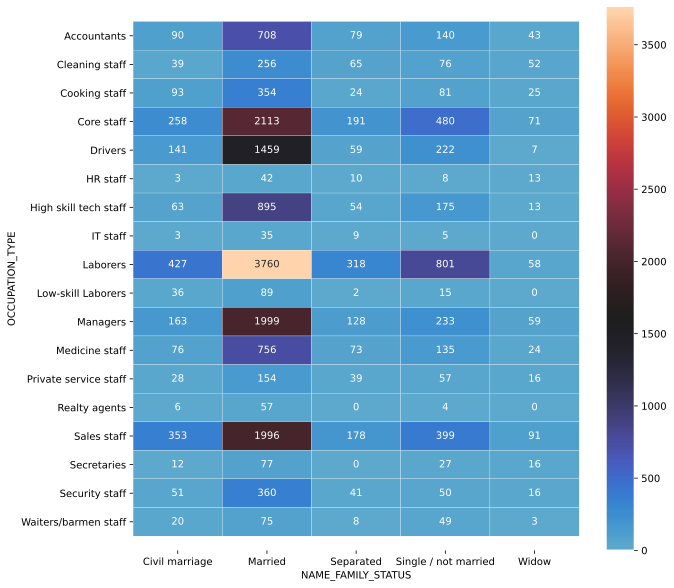

In [43]:
pvt_tbl = pd.pivot_table(data = cust_data, index = ['OCCUPATION_TYPE'], columns = ['NAME_FAMILY_STATUS'], values = 'target', aggfunc = sum,  fill_value = 0)
plt.figure(figsize=[10,10])
hm = sns.heatmap(data = pvt_tbl, annot = True, fmt='.0f', linewidths=.2, center = 1600)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

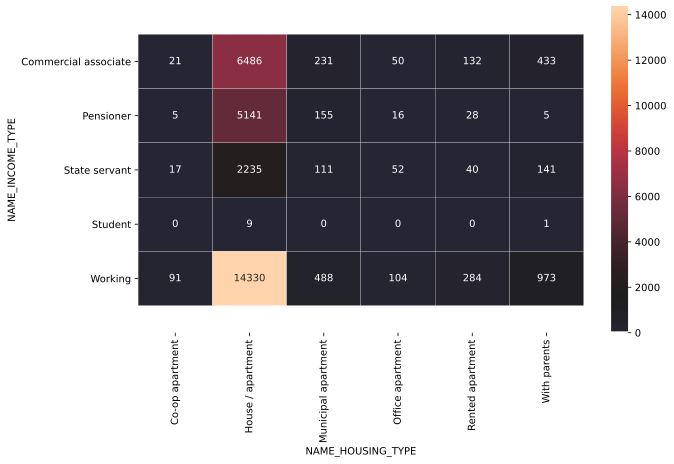

In [44]:
pvt_tbl = pd.pivot_table(data = cust_data, index = ['NAME_INCOME_TYPE'], columns = ['NAME_HOUSING_TYPE'], values = 'target', aggfunc = sum,  fill_value = 0)
plt.figure(figsize=[10,6])
hm = sns.heatmap(data = pvt_tbl, annot = True, fmt='.0f', linewidths=.2, center = 1600)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [45]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32177 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   32177 non-null  int64  
 1   CODE_GENDER          32177 non-null  object 
 2   FLAG_OWN_CAR         32177 non-null  object 
 3   FLAG_OWN_REALTY      32177 non-null  object 
 4   CNT_CHILDREN         32177 non-null  int64  
 5   AMT_INCOME_TOTAL     32177 non-null  float64
 6   NAME_INCOME_TYPE     32177 non-null  object 
 7   NAME_EDUCATION_TYPE  32177 non-null  object 
 8   NAME_FAMILY_STATUS   32177 non-null  object 
 9   NAME_HOUSING_TYPE    32177 non-null  object 
 10  DAYS_BIRTH           32177 non-null  int64  
 11  DAYS_EMPLOYED        32177 non-null  int64  
 12  FLAG_MOBIL           32177 non-null  int64  
 13  FLAG_WORK_PHONE      32177 non-null  int64  
 14  FLAG_PHONE           32177 non-null  int64  
 15  FLAG_EMAIL           32177 non-null 

In [46]:
cust_data.isnull().sum()

ID                        0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
NAME_HOUSING_TYPE         0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_MOBIL                0
FLAG_WORK_PHONE           0
FLAG_PHONE                0
FLAG_EMAIL                0
OCCUPATION_TYPE        9980
CNT_FAM_MEMBERS           0
CUST_FOR_MONTHS           0
target                    0
dtype: int64

In [47]:
#Convert binary categorical columns to have integer value
cust_data['CODE_GENDER'] = cust_data.CODE_GENDER.apply(lambda x : 0 if x == 'M' else 1)
cust_data['FLAG_OWN_CAR'] = cust_data.FLAG_OWN_CAR.apply(lambda x : 0 if x == 'N' else 1)
cust_data['FLAG_OWN_REALTY'] = cust_data.FLAG_OWN_REALTY.apply(lambda x : 0 if x == 'N' else 1)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,1
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,1
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,1


In [48]:
cust_data.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
count,3.217700e+04,32177.000000,32177.000000,32177.000000,32177.000000,3.217700e+04,32177.000000,32177.000000,32177.0,32177.000000,32177.000000,32177.000000,32177.000000,32177.000000,32177.000000
mean,5.078181e+06,0.669267,0.378842,0.671194,0.431395,1.858457e+05,-15976.384871,59795.907387,1.0,0.225285,0.295180,0.089971,2.199521,26.070268,0.981415
std,4.181678e+04,0.470484,0.485106,0.469787,0.745757,1.007217e+05,4214.213798,138116.549593,0.0,0.417776,0.456131,0.286145,0.914533,16.465296,0.135055
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.041913e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,-19457.000000,-3141.000000,1.0,0.000000,0.000000,0.000000,2.000000,12.000000,1.000000
50%,5.074710e+06,1.000000,0.000000,1.000000,0.000000,1.575000e+05,-15565.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,24.000000,1.000000
75%,5.114631e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,-12454.000000,-401.000000,1.0,0.000000,1.000000,0.000000,3.000000,39.000000,1.000000
max,5.150487e+06,1.000000,1.000000,1.000000,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,60.000000,1.000000


In [49]:
#CNT_FAM_MEMBERS can not be float. Convert the column to int type
cust_data['CNT_FAM_MEMBERS'] = cust_data['CNT_FAM_MEMBERS'].astype('int')
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2,15,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2,14,1
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2,29,1
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,4,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,26,1


In [50]:
def box_plot(df,col) :
    sns.boxplot(data = df, y = col)
    plt.show()

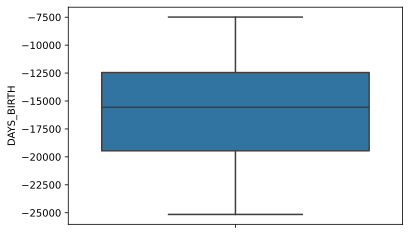

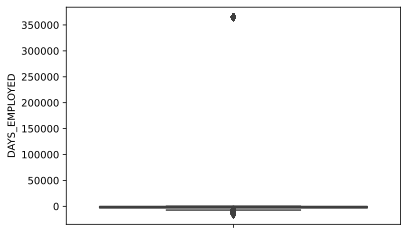

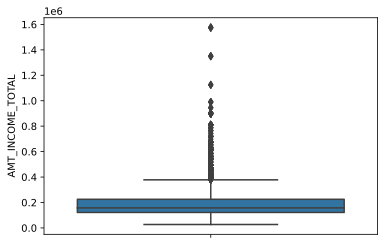

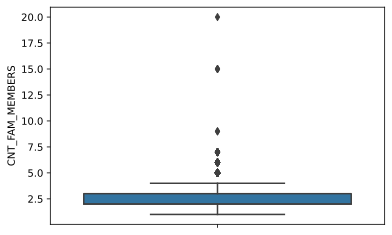

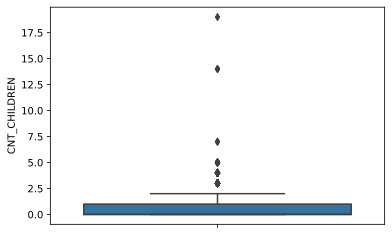

In [51]:
boxplt_col = ["DAYS_BIRTH","DAYS_EMPLOYED","AMT_INCOME_TOTAL","CNT_FAM_MEMBERS","CNT_CHILDREN"]
for col in boxplt_col :
    box_plot(cust_data,col)

In [52]:
#Checking outliers for DAYS_EMPLOYED column
cust_data[cust_data['DAYS_EMPLOYED'] > 0]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
7,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1,20,1
8,5008813,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1,16,1
9,5008814,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1,17,1
69,5008884,1,0,1,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186,365243,1,0,0,0,NaN,1,40,1
150,5008974,1,0,1,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22319,365243,1,0,0,0,NaN,2,49,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36408,5126278,1,0,0,0,162000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21244,365243,1,0,0,0,NaN,2,28,0
36418,5139446,1,0,1,0,112500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21256,365243,1,0,1,0,NaN,1,16,0
36432,5145690,1,0,1,0,306000.0,Pensioner,Higher education,Married,House / apartment,-21590,365243,1,0,0,0,NaN,2,17,0
36434,5145817,1,0,1,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22011,365243,1,0,0,0,NaN,2,39,0


In [53]:
cust_data[(cust_data['DAYS_EMPLOYED'] > 0) & (cust_data.NAME_INCOME_TYPE == 'Pensioner')].shape

(5461, 20)

## All the customers with a positive 'DAYS_EMPLOYED' are pensioners and represent a valid data.

In [54]:
#Convert the Integer columns to positive integers
def convert_to_positive(df,column) :
    df[column] = df[column].apply(lambda x : x*-1)
    return df

In [55]:
continuous_variable = ['DAYS_BIRTH','DAYS_EMPLOYED']
for c in continuous_variable :
    cust_data = convert_to_positive(cust_data,c)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,1,0,0,NaN,2,15,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,1,0,0,NaN,2,14,1
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,21474,1134,1,0,0,0,Security staff,2,29,1
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,19110,3051,1,0,1,1,Sales staff,1,4,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,19110,3051,1,0,1,1,Sales staff,1,26,1


In [56]:
#Convert DAYS to YEARS
cust_data['EMP_YEARS'] = cust_data.DAYS_EMPLOYED/365
cust_data['AGE'] = cust_data.DAYS_BIRTH/365
cust_data.drop(["DAYS_BIRTH","DAYS_EMPLOYED"],axis = 1,inplace = True)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2,15,1,12.443836,32.890411
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2,14,1,12.443836,32.890411
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2,29,1,3.106849,58.832877
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,4,1,8.358904,52.356164
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,26,1,8.358904,52.356164


## Replacing all the EMP_YEARS for all pensioners to be -1.

In [57]:
cust_data['EMP_YEARS'] = cust_data.EMP_YEARS.apply(lambda x : -1 if x<0 else x)

In [58]:
def bad_cust_proportion(col) :
    bad_prop_cnt = cust_data.groupby([col,'target']).agg({'ID': 'count'})
    bad_prop_percent = bad_prop_cnt.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    return bad_prop_percent

In [59]:
bad_cust_proportion('FLAG_OWN_CAR')

ID
FLAG_OWN_CAR target           
0            0        1.926252
             1       98.073748
1            0        1.747334
             1       98.252666

In [61]:
bad_cust_proportion('NAME_HOUSING_TYPE')

ID
NAME_HOUSING_TYPE   target           
Co-op apartment     0        2.189781
                    1       97.810219
House / apartment   0        1.817359
                    1       98.182641
Municipal apartment 0        2.955665
                    1       97.044335
Office apartment    0        3.896104
                    1       96.103896
Rented apartment    0        1.626016
                    1       98.373984
With parents        0        1.646612
                    1       98.353388

In [63]:
bad_cust_proportion('NAME_FAMILY_STATUS')

ID
NAME_FAMILY_STATUS   target           
Civil marriage       0        1.717557
                     1       98.282443
Married              0        1.720625
                     1       98.279375
Separated            0        1.615509
                     1       98.384491
Single / not married 0        2.327221
                     1       97.672779
Widow                0        3.232917
                     1       96.767083

In [64]:
cust_data['OCCUPATION_TYPE'] = cust_data.OCCUPATION_TYPE.apply(lambda x : 'UNEMPLOYED' if pd.isnull(x) else x)
cust_data.OCCUPATION_TYPE.value_counts()

UNEMPLOYED               9980
Laborers                 5460
Core staff               3185
Sales staff              3062
Managers                 2629
Drivers                  1931
High skill tech staff    1229
Accountants              1082
Medicine staff           1074
Cooking staff             586
Security staff            530
Cleaning staff            493
Private service staff     296
Waiters/barmen staff      157
Low-skill Laborers        150
Secretaries               134
HR staff                   77
Realty agents              67
IT staff                   55
Name: OCCUPATION_TYPE, dtype: int64

## Conclusion
### 1. The 20 MOB observe window will be appropriate. Those who exists shorter than the observe window should be excluded from our analysis
### 2. Housing ownership percentage for females is `90.89%` while for males it is `87.58%`. Females applicants have higher house ownership percentage. 
### 3. The average income increases with the education level.
### 4. Mean of income = `87524.29` Median of income = `160780.50` 
### 5. Proportion of bad customers for people who own a car is less than those who don't own a car
### 6. People living on rent don't have the highest proportion of bad customers. People having 'Office apartment' have the highest proportion of bad customers
### 7. Single customers have a higher proportion of bad customers as compared to married customers